# <span style='background-color: #fff5b1'>오늘의 한 걸음  🚶🏽‍♂️: 꿀벌들의 종류 탐방기</span>

## Contexts

### 1. READY
    1-1 오늘의 과제
    1-2 사용하는 라이브러리  

### 2. GAME
    2-1. 데이터 읽어오기  
    2-2. 데이터 전처리  
    2-3. 모델 학습  
        2-3-1. 모델 생성 (CNN)
        2-3-2. 나의 모델  
        2-3-3. 작성자의 모델
    2-4. 데이터 평가   

### 3. POTG
    3-1. 소감


---


a# 1. Ready
## 1-1. 오늘의 과제 

오늘은 캐글에서 진행되었던 꿀벌 분류 대회를 되새김해본다.  
자료 : <a href="https://www.kaggle.com/datasets/jenny18/honey-bee-annotated-images">The BeeImage Dataset: Annotated Honey Bee Images</a>

해당 데이터는 5,100+ 장의 설명이 참조된 꿀벌 사진으로 구성된다.  
위의 자료링크에서 이미지와 cvs 파일을 다운로드할 수 있다.

csv 파일에는 사진의 경로와  
각 사진에 있는 벌들의 Metadata 가 담겨있다.  

우리의 목표는 이 데이터를 이용해서
사진만으로도 이 벌꿀의 종류와 건강상태를 알아내는 것이다 !

나는 가장 많은 hitrate 를 기록한 참가자 드미트리 씨의 링크를 참고하여  
작성했다.

자료 : <a href="https://www.kaggle.com/code/dmitrypukhov/honey-bee-health-detection-with-cnn">DMITRY PUKHOV님의 글, 4년 전</a>


## 1-2. 사용하는 라이브러리

In [40]:
# related to data processing
import pandas as pd
import numpy as np
import random

# related to path
from pathlib import Path
from PIL import Image

# related to display
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display


from pathlib import Path

# Image processing
import imageio
import skimage
import skimage.io
import skimage.transform

# ML
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics

#from sklearn.preprocessing import OneHotEncoder
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
import tensorflow


# image pre-setting
img_width=100
img_height=100
img_channels=3

print("슝 =3")


슝 =3


# 2. Game
## 2-1. 데이터 읽어오기

In [4]:
df = pd.read_csv('./bee_data.csv', delimiter=',')
df.dataframeName = 'bee_data.csv'
nRow, nCol = df.shape

print(f'There are {nRow} rows and {nCol} columns below')
df.head()

There are 5172 rows and 9 columns below


,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


해당 csv 파일은 5172 개의 꿀벌 사진 경로와  
그에 따른 9개의 정보를 제공해주고 있다.

|column|context|
|------|---|
|file|데이터 경로|
|date|찍은 날짜|
|time|찍은 시간|
|location|찍힌 장소|
|zip code|찍힌 장소의 주소|
|subspecies|벌꿀 종류 (이탈리아산, 러시아산, 그 외)|
|health|벌꿀 건강상태 (건강, 다리 다침 등)|
|pollen carrying|벌이 꽃가루를 지녔는지 유무|
|caste|계급 (일꾼, 정찰병, 여왕벌)|



위의 그래프를 봤는데 subspecies 나 caste 가 다  
똑같은 애들만 있는 것 같아 보인다.  
따라서 전체적인 분포도가 어떻게 되는지 시각화하였다.

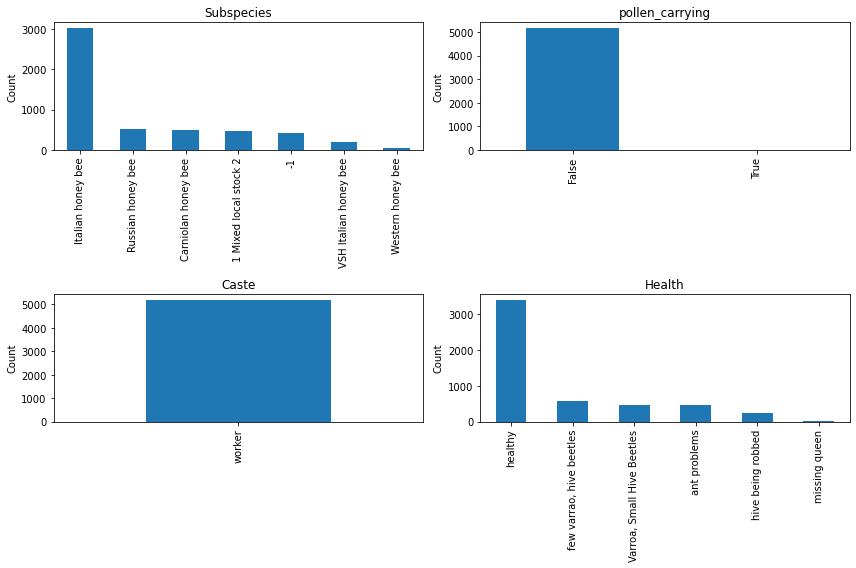

In [8]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

df.subspecies.value_counts().plot(kind='bar',ax=ax[0, 0])
ax[0,0].set_ylabel('Count')
ax[0,0].set_title('Subspecies')

df.subspecies.value_counts().plot(kind='bar',ax=ax[0, 0])
ax[0,0].set_ylabel('Count')
ax[0,0].set_title('Subspecies')

df.pollen_carrying.value_counts().plot(kind='bar', ax=ax[0, 1])
ax[0,1].set_title('pollen_carrying')
ax[0,1].set_ylabel('Count')

df.caste.value_counts().plot(kind='bar', ax=ax[1, 0])
ax[1,0].set_title('Caste')
ax[1,0].set_ylabel('Count')

df.health.value_counts().plot(kind='bar', ax=ax[1,1])
ax[1,1].set_title('Health')
ax[1,1].set_ylabel('Count')

f.subplots_adjust(hspace=0.7)
f.tight_layout()
plt.show()

이 분포도를 통해 알 수 있는 것은  
1. 모든 꿀벌은 일병이다.
2. 99%의 꿀벌에게는 꽃가루가 안 묻어 있다.
3. 80%의 꿀벌은 이탈리아 태생이다.
4. 80%의 꿀벌은 건강하다.

우리 데이터셋의 꿀벌의 페르소나는  
이탈리아 태생의  
꽃따위 신경 안쓰는  
마초 건강벌이다.

그 얼굴을 한번 구경해 보자.

The image size is: (68, 64)


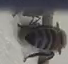

In [10]:

img = Image.open('./bee_imgs/bee_imgs/001_043.png')

# Get the image size
img_size = img.size
print("The image size is: {}".format(img_size))

# Just having the image as the last line in the cell will display it in the notebook
img

c:\Users\82102\miniconda3\envs\inha\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  # This is added back by InteractiveShellApp.init_path()


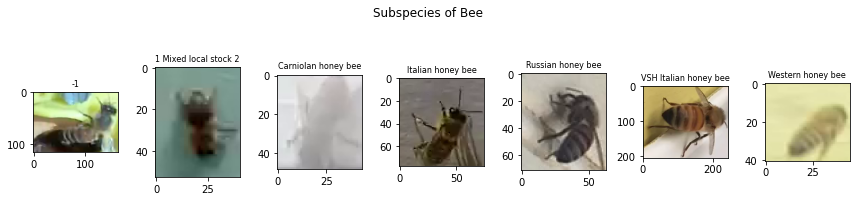

In [51]:
img_folder='./bee_imgs/bee_imgs/'


subspecies = df['subspecies'].astype('category').cat.categories
f, ax = plt.subplots(nrows=1,ncols=subspecies.size, figsize=(12,3))
i=0
# Draw the first found bee of given subpecies
for s in subspecies:
    if s == 'healthy': continue
    file=img_folder + df[df['subspecies']==s].iloc[0]['file']
    im=imageio.imread(file)
    ax[i].imshow(im, resample=True)
    ax[i].set_title(s, fontsize=8)
    i+=1
    
plt.suptitle("Subspecies of Bee")
plt.tight_layout()
plt.show()

c:\Users\82102\miniconda3\envs\inha\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


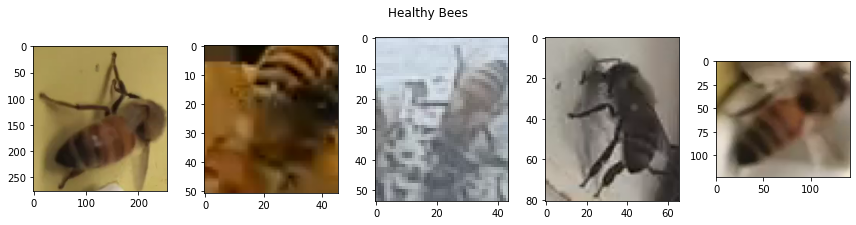

In [53]:
ncols = 5
healthy = df[df['health'] == 'healthy'].sample(ncols)

f, ax = plt.subplots(nrows=1,ncols=ncols, figsize=(12,3))
# Read image of original size from disk, because bees['img'] contains resized numpy array
for i in range(0,5): 
    file = img_folder + healthy.iloc[i]['file']
    ax[i].imshow(imageio.imread(file))

plt.suptitle("Healthy Bees")
plt.tight_layout()
plt.show()

c:\Users\82102\miniconda3\envs\inha\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  import sys


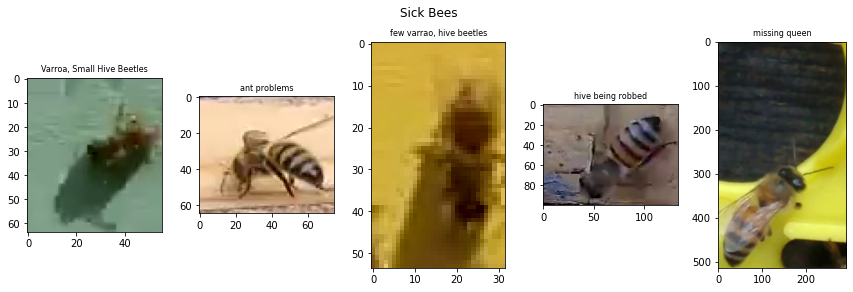

In [55]:
health_cats = df['health'].astype('category').cat.categories
f, ax = plt.subplots(1, health_cats.size-1, figsize=(12,4))
i=0
for c in health_cats:
    if c == 'healthy': continue
    bee = df[df['health'] == c].sample(1).iloc[0]
    ax[i].imshow(imageio.imread(img_folder + bee['file']))
    ax[i].set_title(bee['health'], fontsize=8)
    i += 1
    
plt.suptitle("Sick Bees")    
plt.tight_layout()
plt.show()

사진마다 가로세로 길이가 다르며,  
화질도 깨지고,  
벌이 존재하는 장소도 각 다른 것을 볼 수 있다.


## 2-1. 전처리

해당 데이터를 위에서 봤듯이,  
데이터의 비율이  
특정 종, 특정 나라에 치우쳐져 있다.

때문에 각 데이터들의 비율을 맞춰  
모델 학습 시의 편차를 줄인다.

In [71]:

# 데이터 균형 함수
def split_balance(df, field_name):
    """
    train, test, val 데이터로 분리 후, 
    각 아이템 별 valancing 작업

    Args:
        df (_type_): 전체 꿀벌 데이터
        field_name (_type_): 균형을 맞출 카테고리 필드

    Returns:
        편향을 제거한 train, test, val 데이터
    """
    # Split to train and test before balancing
    train_bees, test_bees = train_test_split(df, random_state=24)
    train_bees, val_bees = train_test_split(train_bees, test_size=0.1, random_state=24)

    
    #총 데이터를 7개인 카테고리 수로 나눔
    ncat_bal = int(len(train_bees)/train_bees[field_name].astype('category').cat.categories.size)
    
    #각 카테고리가 같을 수 있도록 하나씩 가져옴
    train_bees_bal = train_bees.groupby(field_name, as_index=False).apply(lambda g:  g.sample(ncat_bal, replace=True)).reset_index(drop=True)
    return(train_bees_bal, val_bees, test_bees)


In [69]:
# 그래프를 그리는 함수
def plot_balanced(train_bees, train_bees_bal, field_name):
    """
    균형이 맞춰지기 전후 데이터를 그려 비교한다.

    Args:
        train_bees      : 균형을 맞추기 전 데이터
        train_bees_bal  : 균형이 맞춰진 데이터
        field_name      : 그리고 싶은 필드 이름
    """

    # Plot before and after balancing
    f, axs = plt.subplots(1,2, figsize=(8,4))

    # Before
    ax = train_bees[field_name].value_counts().plot(kind='bar', ax=axs[0])
    ax.set_title('%s before balancing' % field_name)
    ax.set_ylabel('Count')

    # After
    ax = train_bees_bal[field_name].value_counts().plot(kind='bar', ax=axs[1])
    ax.set_title('%s after balancing' % field_name)
    ax.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

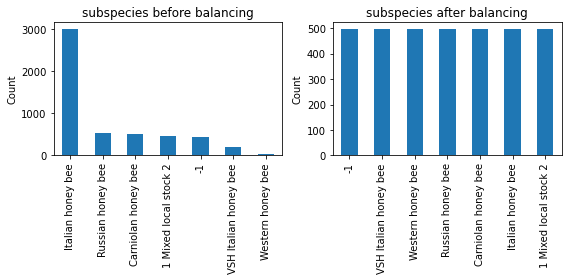

In [70]:
train_bees_bal, val_bees, test_bees = split_balance(df, 'subspecies')
plot_balanced(df, train_bees_bal, 'subspecies')

# Will use balanced dataset as main
train_bees = train_bees_bal

이후에는 `ImageDataGeneraotr` 클래스를 사용해  
각 이미지들을 무작위하게 회전, 이동, 확대 잡음을 추가하는  
Argumentation 작업 이후 불러왔다.

In [80]:
def read_img(file):
    """
    크기와 채널을 조정해준다. 
    Caution: This function is not independent, it uses global vars: img_folder, img_channels
    """
    img = skimage.io.imread(img_folder + file)
    img = skimage.transform.resize(img, (img_width, img_height), mode='reflect')
    return img[:,:,:img_channels]

def prepare_train(train_bees, val_bees, test_bees, field_name):
    """
    이미지 사진을 가져온다
    라벨을 원핫인코딩 한다.
    @return: image generator, train images, validation images, test images, train labels, validation labels, test labels
    """

    # Train data
    train_X = np.stack(train_bees['file'].apply(read_img)) #새로운 축 추가해서 행렬 합침
    train_y  = pd.get_dummies(train_bees[field_name], drop_first=False) # 0 1 0 0 처럼 각 종류에 원핫 인코딩

    # Validation during training data to calc val_loss metric
    val_X = np.stack(val_bees['file'].apply(read_img))
    val_y = pd.get_dummies(val_bees[field_name], drop_first=False)

    # Test data
    test_X = np.stack(test_bees['file'].apply(read_img))
    test_y = pd.get_dummies(test_bees[field_name], drop_first=False)


    # Data augmentation - 조금씩 회전, 확대, 이동 하여 데이터를 추가하였다.
    generator = ImageDataGenerator(
            featurewise_center=False,           # set input mean to 0 over the dataset
            samplewise_center=False,            # set each sample mean to 0
            featurewise_std_normalization=False,# divide inputs by std of the dataset
            samplewise_std_normalization=False, # divide each input by its std
            zca_whitening=False,                # apply ZCA whitening
            rotation_range=180,                 # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1,                   # Randomly zoom image 
            width_shift_range=0.2,              # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.2,             # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,               # randomly flip images
            vertical_flip=True)

    generator.fit(train_X)
    return (generator, train_X, val_X, test_X, train_y, val_y, test_y)

generator, train_X, val_X, test_X, train_y, val_y, test_y = prepare_train(train_bees, val_bees, test_bees, 'subspecies')

# 2-3. 모델 학습

## 2-3-1. 모델 생성

우리가 이번에 쓰는 모델은 CNN 모델이다.
내가 예전에 사용해보았던 CNN 과  
이번에 참조한 작성자의 CNN 을 비교해 보았다.

## 2-3-2. 나의 모델
나의 모델은 예전 아이펠 수강 시에  
폐렴 이미지를 분류하기 위해 쓰였던 CNN 이다.

자료 : <a href="https://github.com/xman227/Aiffel_oHA/blob/master/Exploration_09_(CNN)/%5BE-09%5DpneumoniaOX.ipynb">폐렴환자의 x-ray 이미지 구분</a>

In [86]:
import tensorflow as tf

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)

    ])
    
    return block


def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(100, 100, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        #dense_block(32, 0.3), #내가 새로 추가한 모델
        
        tf.keras.layers.Dense(train_y.columns.size, activation='softmax')
    ])
    
    return model

model1 = build_model()
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

training1 = model1.fit_generator(generator.flow(train_X,train_y, batch_size=60)
                        ,epochs=20
                        ,validation_data=(val_X, val_y) #[val_X, val_Y] 를 하면 안댐
                        ,steps_per_epoch=50)


Epoch 1/20
50/50 [==============================] - 42s 832ms/step - loss: 2.1594 - accuracy: 0.2396 - val_loss: 2.0159 - val_accuracy: 0.0309
Epoch 2/20
50/50 [==============================] - 33s 654ms/step - loss: 1.5495 - accuracy: 0.4036 - val_loss: 1.9397 - val_accuracy: 0.0928
Epoch 3/20
50/50 [==============================] - 39s 780ms/step - loss: 1.2934 - accuracy: 0.4647 - val_loss: 1.8314 - val_accuracy: 0.0928
Epoch 4/20
50/50 [==============================] - 33s 669ms/step - loss: 1.0670 - accuracy: 0.5600 - val_loss: 1.8125 - val_accuracy: 0.0309
Epoch 5/20
50/50 [==============================] - 35s 705ms/step - loss: 0.9179 - accuracy: 0.6324 - val_loss: 1.8841 - val_accuracy: 0.0309
Epoch 6/20
50/50 [==============================] - 33s 663ms/step - loss: 0.8307 - accuracy: 0.6694 - val_loss: 1.9953 - val_accuracy: 0.0309
Epoch 7/20
50/50 [==============================] - 33s 651ms/step - loss: 0.7320 - accuracy: 0.7254 - val_loss: 1.9782 - val_accuracy: 0.0309

## 2-3-3. 작성자의 CNN
작성자님이 제시해준 모델은 다음과 같다.

In [74]:
# We'll stop training if no improvement after some epochs
earlystopper1 = EarlyStopping(monitor='loss', patience=10, verbose=1)

# Save the best model during the traning
checkpointer1 = ModelCheckpoint('best_model1.h5'
                                ,monitor='val_acc'
                                ,verbose=1
                                ,save_best_only=True
                                ,save_weights_only=True)
# Build CNN model
model2=Sequential()
model2.add(Conv2D(6, kernel_size=3, input_shape=(img_width, img_height,3), activation='relu', padding='same'))
model2.add(MaxPool2D(2))
model2.add(Conv2D(12, kernel_size=3, activation='relu', padding='same'))
model2.add(Flatten())
model2.add(Dense(train_y.columns.size, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
training2 = model2.fit_generator(generator.flow(train_X,train_y, batch_size=60)
                        ,epochs=20
                        ,validation_data=(val_X, val_y) #[val_X, val_Y] 를 하면 안댐
                        ,steps_per_epoch=50
                        ,callbacks=[earlystopper1, checkpointer1])
# Get the best saved weights
#model1.load_weights('../best_model1.h5')

Epoch 1/20
50/50 [==============================] - 10s 196ms/step - loss: 1.3365 - accuracy: 0.4973 - val_loss: 1.2958 - val_accuracy: 0.4304
Epoch 2/20
50/50 [==============================] - 9s 181ms/step - loss: 0.7029 - accuracy: 0.7665 - val_loss: 0.7242 - val_accuracy: 0.7113
Epoch 3/20
50/50 [==============================] - 9s 180ms/step - loss: 0.5621 - accuracy: 0.8062 - val_loss: 0.9899 - val_accuracy: 0.6134
Epoch 4/20
50/50 [==============================] - 9s 176ms/step - loss: 0.4980 - accuracy: 0.8337 - val_loss: 0.9174 - val_accuracy: 0.6624
Epoch 5/20
50/50 [==============================] - 9s 175ms/step - loss: 0.4525 - accuracy: 0.8469 - val_loss: 0.6973 - val_accuracy: 0.7552
Epoch 6/20
50/50 [==============================] - 9s 179ms/step - loss: 0.4302 - accuracy: 0.8534 - val_loss: 0.7919 - val_accuracy: 0.6778
Epoch 7/20
50/50 [==============================] - 11s 229ms/step - loss: 0.4508 - accuracy: 0.8394 - val_loss: 0.7756 - val_accuracy: 0.7320
Epoc

# 2-4. 데이터 평가
내가 만든 모델과  
작성자님의 모델을 평가하기 위해  

사전에 미리 분류하였던 test 데이터를 바탕으로 정확도를 측정하였다.

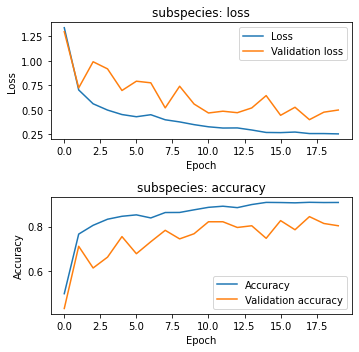

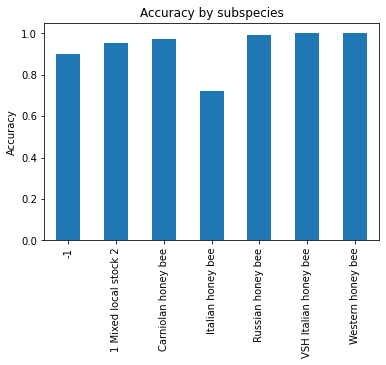

Classification report
                       precision    recall  f1-score   support

                   -1       0.84      0.94      0.89       108
1 Mixed local stock 2       0.42      0.95      0.58       102
  Carniolan honey bee       0.98      0.98      0.98       147
    Italian honey bee       0.99      0.74      0.85       754
    Russian honey bee       0.98      0.99      0.98       124
VSH Italian honey bee       0.54      1.00      0.70        54
    Western honey bee       1.00      1.00      1.00         4

             accuracy                           0.84      1293
            macro avg       0.82      0.94      0.85      1293
         weighted avg       0.91      0.84      0.85      1293

Loss function: 0.4203888773918152, accuracy: 0.836040198802948


In [77]:
def eval_model(training, model, test_X, test_y, field_name):
    """
    예측값과 test 데이터를 바탕으로 정확도 예측
    시각화
    """
    ## Trained model analysis and evaluation
    f, ax = plt.subplots(2,1, figsize=(5,5))
    ax[0].plot(training.history['loss'], label="Loss")
    ax[0].plot(training.history['val_loss'], label="Validation loss")
    ax[0].set_title('%s: loss' % field_name)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    # Accuracy
    ax[1].plot(training1.history['accuracy'], label="Accuracy")
    ax[1].plot(training1.history['val_accuracy'], label="Validation accuracy")
    ax[1].set_title('%s: accuracy' % field_name)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

    # Accuracy by subspecies
    test_pred = model.predict(test_X)
    
    acc_by_subspecies = np.logical_and((test_pred > 0.5), test_y).sum()/test_y.sum()
    acc_by_subspecies.plot(kind='bar', title='Accuracy by %s' % field_name)
    plt.ylabel('Accuracy')
    plt.show()

    # Print metrics
    print("Classification report")
    test_pred = np.argmax(test_pred, axis=1)
    test_truth = np.argmax(test_y.values, axis=1)
    print(metrics.classification_report(test_truth, test_pred, target_names=test_y.columns))

    # Loss function and accuracy
    test_res = model.evaluate(test_X, test_y.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

eval_model(training2, model2, test_X, test_y, 'subspecies')

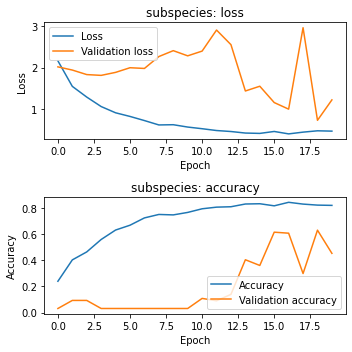

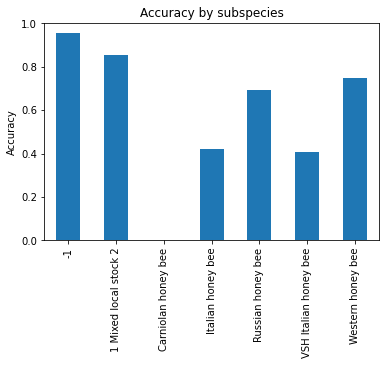

Classification report
                       precision    recall  f1-score   support

                   -1       0.38      0.95      0.54       108
1 Mixed local stock 2       0.24      0.86      0.37       102
  Carniolan honey bee       0.00      0.00      0.00       147
    Italian honey bee       0.94      0.44      0.60       754
    Russian honey bee       0.39      0.76      0.52       124
VSH Italian honey bee       0.50      0.46      0.48        54
    Western honey bee       1.00      1.00      1.00         4

             accuracy                           0.50      1293
            macro avg       0.49      0.64      0.50      1293
         weighted avg       0.66      0.50      0.50      1293

Loss function: 1.2568470239639282, accuracy: 0.49961331486701965


In [87]:
eval_model(training1, model1, test_X, test_y, 'subspecies')

작성자님 모델 결과 acc 0.83, 내 모델 결과 acc 0.49 로 약 두 배 정도 차이가 난다.

# 3. POTG
## 3-1. 소감

**" 🌞 데이터 로드부터 전처리, 학습, 평가까지 한 싸이클을 돌렸습니다 ! "**

역시 내 모델에 비해 참가자님 것이 훨씬 잘 적중한다..  
해당 과제에 맞게 fine tune 되어있기 때문이다.

이에 따라 다음의 과제에서도 문제를 정확히 파악하고  
최적화된 모델을 학습시켜야 할 것이다.